<a href="http://cocl.us/pytorch_link_top?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork20647850-2021-01-01">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions:

<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">

<ul>
    <li><a href="https://#download_data"> Download Data</a></li>
    <li><a href="https://#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="https://#data_class"> Dataset Class</a></li>
    <li><a href="https://#Question_1">Question 1</a></li>
    <li><a href="https://#Question_2">Question 2</a></li>
    <li><a href="https://#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [11]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip -P https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources

--2022-02-25 14:50:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources/Positive_tensors.zip.1’

Positive_tensors.zi 100%[===================>]   2.42G  37.7MB/s    in 67s     

2022-02-25 14:51:59 (37.0 MB/s) - ‘https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources/Positive_tensors.zip.1’ saved [2598656062/2598656062]



In [21]:
!unzip -q https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources/Positive_tensors.zip.1 -d https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources

In [13]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip.1 -P https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources

--2022-02-25 14:52:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources/Negative_tensors.zip.1’

Negative_tensors.zi 100%[===================>]   1.97G  37.3MB/s    in 55s     

2022-02-25 14:52:56 (36.6 MB/s) - ‘https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources/Negative_tensors.zip.1’ saved [2111408108/2111408108]



In [22]:
!unzip -q https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources/Negative_tensors.zip.1 -d https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources

We will install torchvision:


In [15]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [16]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob


In [17]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [18]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="https://s3.private.au-syd.cloud-object-storage.appdomain.cloud/ibm-ai-capstone-bucket/Resources/"
        #directory=""
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [19]:
# set the seed
torch.manual_seed(0)

# create transforms using mean and std for the resnet18 model
mean = [0.485, 0.456, 0.4086]
std = [0.229, 0.224, 0.225]
        
transform = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Resize(224),
#    transforms.ToPILImage(),
    transforms.Normalize(mean, std)
]
)

In [24]:
train_dataset = Dataset(transform=transform, train=True)
validation_dataset = Dataset(transform=transform, train=False)
len(train_dataset)

30000

In [25]:
sample=train_dataset[0][0]
sample.shape

torch.Size([3, 224, 224])

In [26]:
input_dim = train_dataset[0][0].shape[0] * train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
input_dim

150528

<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [27]:
# Step 1: Load the pre-trained model resnet18

# Type your code here
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/wsuser/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [28]:
# Step 2: Set the parameter cannot be trained for the pre-trained model


# Type your code here
for param in model.parameters():
    param.requires_grad=False 

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [29]:
model.fc = nn.Linear(in_features=512, out_features=2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [30]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function


In [31]:
# Step 1: Create the loss function

# Type your code here
criterion=nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [32]:
train_batch = 100
validation_batch = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=validation_batch)

<b>Step 3</b>: Use the following optimizer to minimize the loss


In [33]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad], lr=0.003)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [34]:
# Train and Validate
train=True

# Run Parameters initialization
n_epochs=1
loss_list=[]
accuracy_list=[]
loss_epoch = []
accuracy_epoch = []
missed_list = []
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()

start_time = time.time()
for epoch in range(n_epochs):
    print("epoch: {} started...".format(epoch))
    
    if train:
        Loss=0.0
        #set the model to train
        model.train() 
        for x, y in train_loader:
            #clear gradient 
            optimizer.zero_grad()
            #make a prediction 
            yhat = model.forward(x)
            # calculate loss 
            loss = criterion(yhat, y)
            # calculate gradients of parameters 
            loss.backward()
            # update parameters 
            optimizer.step()
            Loss += loss.item()
            loss_list.append(loss.item())

        loss_epoch.append(Loss / N_train)
        print("training done...")
    
    print("starting validation...")
    correct=0.0
    # set model to eval 
    model.eval()
    for x_test, y_test in validation_loader:
        
        #make a prediction 
        yhat = model.forward(x_test)
        #find max 
        pred = torch.max(yhat, 1)
        #Calculate misclassified  samples in mini-batch 
        acc = ((pred.indices == y_test).sum().item()) / validation_batch
        correct += acc
        accuracy_list.append(acc)
        missed_list.append((pred.indices!=y_test).numpy())

    accuracy_epoch.append(correct/len(validation_loader))
    print("epoch {} loss:{} accuracy:{}".format(epoch, Loss/N_train, correct/len(validation_loader)))


epoch: 0 started...
training done...
starting validation...
epoch 0 loss:0.0005850536915939301 accuracy:0.9942999999999996


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [35]:
#accuracy_epoch.append(correct/len(validation_loader))
print("epoch {} loss:{} accuracy:{}".format(epoch, Loss/N_train, correct/len(validation_loader)))
#accuracy_list 

epoch 0 loss:0.0005850536915939301 accuracy:0.9942999999999996


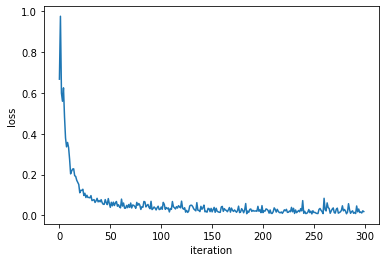

In [36]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


In [37]:
missed = np.array(missed_list).flatten() #.tolist()

ind = 0
index = []
samplemissed = []
for i in range(10000):
    if missed[ind]==True:
        samplemissed.append(validation_dataset[i][0])
        index.append(i)
    ind+=1

len(samplemissed)

In [41]:
def show(sample, transform):
 
    # convert the tensor to PIL image using above transform
    img = transform(sample)

    # display the PIL image
    img.show()



<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [59]:
index
model.eval()
for i in range(4):
    x_test, y_test= validation_dataset[index[i]][0].reshape([1,3,224,224]), validation_dataset[index[i]][1].reshape(1)
    #print(y_test, x_test)
    #make a prediction 
    yhat = model.forward(x_test)
    #find max 
    pred = torch.max(yhat, 1)
    print("sample {} predicted value:{} actual value:{}".format(index[i], pred.indices, y_test))
    #show(x_test.reshape([3,224,224]), transform)


sample 0 predicted value:tensor([0]) actual value:tensor([1])
sample 302 predicted value:tensor([0]) actual value:tensor([1])
sample 648 predicted value:tensor([0]) actual value:tensor([1])
sample 900 predicted value:tensor([0]) actual value:tensor([1])


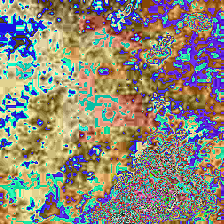

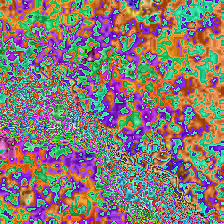

In [42]:
# define a transform to convert a tensor to PIL image
transform = transforms.ToPILImage()

sample1=samplemissed[21]
sample2=validation_dataset[222][0]

show(sample1, transform)
show(sample2, transform)

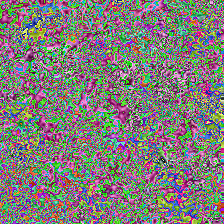

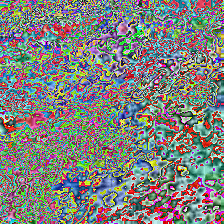

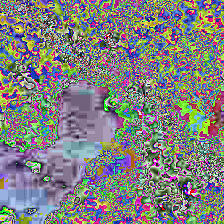

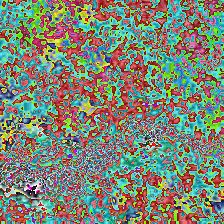

In [43]:
for sample  in samplemissed[0:4]:
    show(sample, transform)


In [44]:
torch.save(model.state_dict(), 'classifier_resnet18_model-fc512x2.state_dict.h5')
torch.save(model, 'classifier_resnet18_model-fc512x2.h5')

In [46]:

# @hidden_cell
# The following code contains the credentials for a bucket in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share the notebook.
credentials = {
    'url': 'https://s3.au-syd.cloud-object-storage.appdomain.cloud',
    'api_key': 'G3p91JL6I-LSeEzChHi-7a3sHa5VEt0Qn-8zwPOSEoeY',
    'resource_instance_id': 'crn:v1:bluemix:public:cloud-object-storage:global:a/a4eded915eba49258c9cb8ac6e309eb3:6e7b0cd8-44b2-43d2-b086-fa76b1e161b3::',
    'iam_url': 'https://iam.cloud.ibm.com/identity/token',
    'bucket': 'ibm-ai-capstone-bucket'
}


In [47]:
from ibm_botocore.client import Config
import ibm_boto3
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['api_key'],
    ibm_service_instance_id=credentials['resource_instance_id'],
    ibm_auth_endpoint=credentials['iam_url'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['url'])

cos.upload_file(Filename='classifier_resnet18_model-fc512x2.h5',Bucket=credentials['bucket'], Key='classifier_resnet18_model-fc512x2.h5')

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print()

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork20647850-2021-01-01"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork20647850-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                                          |
| ----------------- | ------- | ---------- | ----------------------------------------------------------- |
| 2020-09-21        | 2.0     | Shubham    | Migrated Lab to Markdown and added to course repo in GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


Copyright © 2018 <a href="https://cognitiveclass.ai/?utm_medium=dswb&utm_source=bducopyrightlink&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork20647850-2021-01-01&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork20647850-2021-01-01">MIT License</a>.
